In [1]:
using MNIST
trainX, trainY = traindata()
trainX = (trainX - mean(trainX))/var(trainX); #normalise

784x60000 Array{Float64,2}:
 -0.00539757  -0.00539757  -0.00539757  …  -0.00539757  -0.00539757
 -0.00539757  -0.00539757  -0.00539757     -0.00539757  -0.00539757
 -0.00539757  -0.00539757  -0.00539757     -0.00539757  -0.00539757
 -0.00539757  -0.00539757  -0.00539757     -0.00539757  -0.00539757
 -0.00539757  -0.00539757  -0.00539757     -0.00539757  -0.00539757
 -0.00539757  -0.00539757  -0.00539757  …  -0.00539757  -0.00539757
 -0.00539757  -0.00539757  -0.00539757     -0.00539757  -0.00539757
 -0.00539757  -0.00539757  -0.00539757     -0.00539757  -0.00539757
 -0.00539757  -0.00539757  -0.00539757     -0.00539757  -0.00539757
 -0.00539757  -0.00539757  -0.00539757     -0.00539757  -0.00539757
 -0.00539757  -0.00539757  -0.00539757  …  -0.00539757  -0.00539757
 -0.00539757  -0.00539757  -0.00539757     -0.00539757  -0.00539757
 -0.00539757  -0.00539757  -0.00539757     -0.00539757  -0.00539757
  ⋮                                     ⋱                          
 -0.00539757  -0.005

In [62]:
#params
d = 784
n = 32
N = 60000

T = 100
t = linspace(0,1300,T);

#need to get proper data... (note that this data is normalized)
data = trainX#randn((d,N));
Y = trainX#randn((d,N)); 


#which modes are we watching?
indexs = [1, 2, 3, 5, 12, 18, 31];

In [3]:
### Whiten the data -- i dont think this is working?!?
#Decorrelate with PCA
Ux, Sx, Vx = svd(data)
println(size(Ux),size(Sx),size(Vx))
X = transpose(Ux)*data
print(size(X))

(784,784)(784,)(60000,784)
(784,60000)

In [4]:
### SVD decomposition of covar(Y,X) -- covar also needs normalising?
Uyx,Syx,Vyx = svd(Y*transpose(X))
println(size(Uyx),size(Syx),size(Vyx))
Syx = Syx/sqrt(N)

(784,784)(784,)(784,784)


784-element Array{Float64,1}:
 9.88505    
 2.01154    
 1.56382    
 1.35014    
 1.1614     
 0.950437   
 0.802912   
 0.640751   
 0.627811   
 0.522522   
 0.466126   
 0.454961   
 0.412286   
 ⋮          
 9.87715e-16
 9.87715e-16
 9.87715e-16
 9.87715e-16
 9.87715e-16
 9.87715e-16
 9.87715e-16
 9.87715e-16
 9.87715e-16
 9.87715e-16
 9.87715e-16
 8.95733e-16

In [46]:
### Initialize orthonormal weight matrices
#svd of some random matrix
#pick subset of n rows of U
R = svd(randn((784,784)))[1][1:n,:]

#???
D_a = diagm(randn(784))
D_b = diagm(randn(784))

function initweights() #eqns from saxe
    return (Uyx*D_a*transpose(R),R*D_b*Vyx) #dxn#nxd
end

A,B = initweights()
println(size(A),size(B))

(784,32)(32,784)


In [6]:
### now let's train it
#params
η = 0.1e-3;

In [7]:
### Linear NN
function LinearLoss(A,B,x)
    sum(((x-A*B*x)).^2)
end


using ReverseDiffSource
input = X[:,1]
LineardLdW = rdiff(LinearLoss, (A,B,input), ignore=[:input]);
dA,dB = LineardLdW(A,B,X)[2:4];

Loss = 0.0404107602680976
dA: (784,32)  dB: (32,784)

In [50]:
function train(dL)
    A,B = initweights()
    modes = zeros((n,T))
    for i in 1:T
        U,S,V = svd(A*B)
        modes[1:n,i] = S[1:n]

        #grad descent -- am i supposed to be doing this with batches?
        dA,dB = dLdW(A,B,X)[2:4];
        A -= η*dA
        B -= η*dB
    end
    return modes
end

train (generic function with 1 method)

In [18]:
using PyPlot
xkcd();

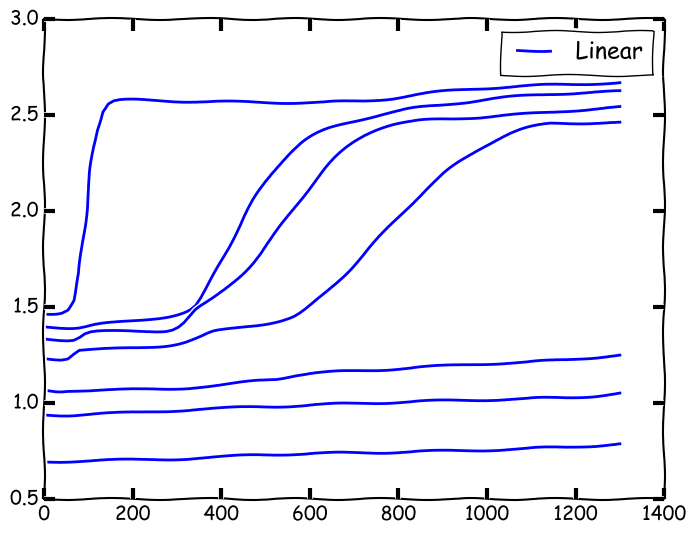

PyObject <matplotlib.legend.Legend object at 0x31d3ca2e8>

In [9]:
linearmodes = train(LineardLdW)
for i in indexs
    plot(t,reshape(linearmodes[i,:],T),c="blue")
end
legend(["Linear"])

In [ ]:
### Non-linear -- Rectifier
function reluLoss(A,B,x) 
    z1 = B*x
    z2 = A*max(0,z1)
    return sum((x - max(0,z2)).^2)
end

input = X[:,1]
reludLdW = rdiff(reluLoss, (A,B,input), ignore=[:input]);
reluModes = train(reludLdW)

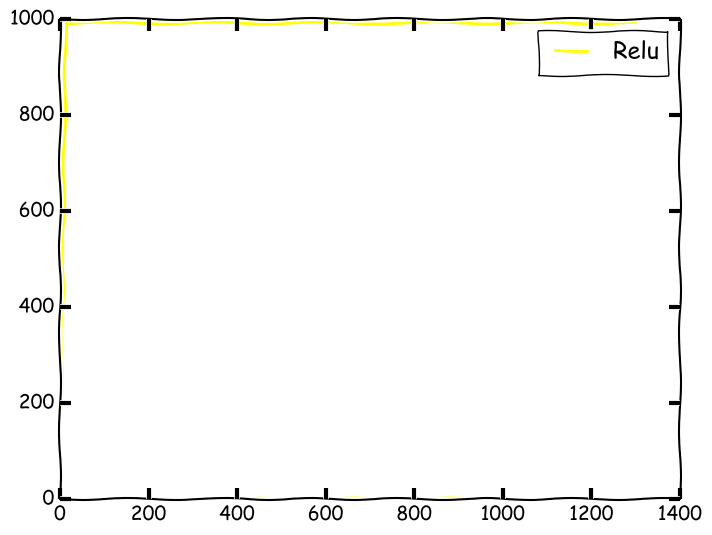

PyObject <matplotlib.legend.Legend object at 0x31bc60860>

In [65]:
for i in indexs
    plot(t,reshape(reluModes[i,:],T),c="yellow")
end
legend(["Relu"])

In [ ]:
# Softplus
function NonLinLoss(A,B,x)
    z1 = log(1.+e.^(B*x))
    z2 = log(1.+e.^(A*z1))
    return sum((x - z2).^2)
end

softplusdLdW = rdiff(NonLinLoss, (A,B,input), ignore=[:input]);
SoftplusModes = train(softplusdLdW)

for i in indexs
    plot(t,reshape(SoftplusModes[i,:],T),c="green")
end
legend(["Softplus"])

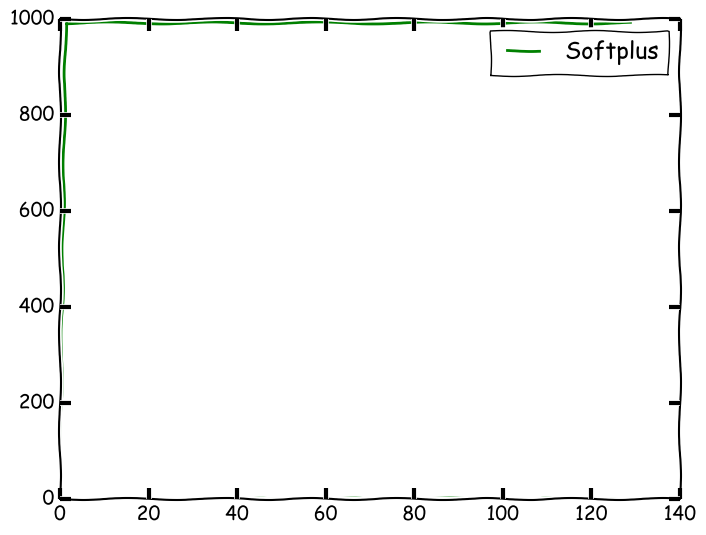

PyObject <matplotlib.legend.Legend object at 0x31bbfdf28>

In [37]:
# ELU


# Maxout (?)

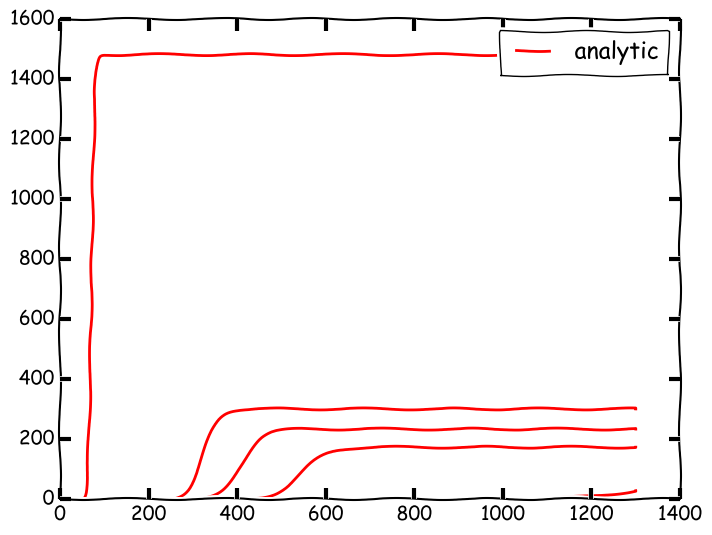

PyObject <matplotlib.legend.Legend object at 0x31d7959e8>

In [67]:
### Analytic
t = linspace(0,1300,1000)
f(t,tau,s,u0) = s*exp(2*s.*t/tau)./(exp(2*s.*t./tau) - 1 + s/u0)
for i in indexs
    plot(t,f(t,1/η,150*Syx[i],1e-6),c="red")
end
legend(["analytic"])